## Подключим все требуемые модули

In [1]:
from openhsl.hsi import HSImage
from openhsl.hs_mask import HSMask
from openhsl.models.ssftt import SSFTT
from openhsl.utils import draw_fit_plots, draw_colored_mask
from openhsl.data.utils import convert_to_color_, get_palette

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report


## RGB изображение ГСА и снимаемой сцены

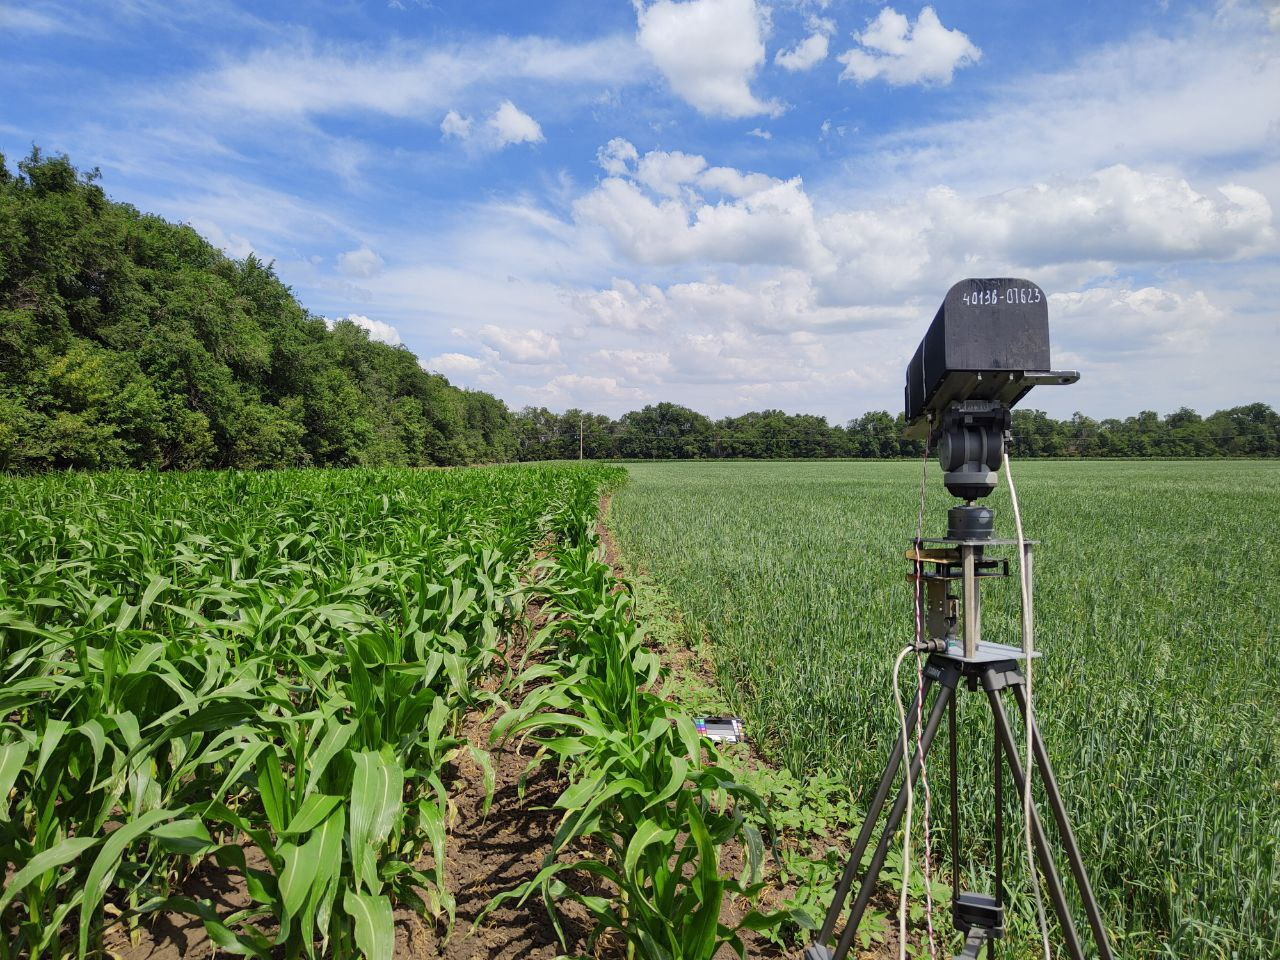

## Зададим пути и ключи доступа для файлов, где хранятся ГСИ и маска разметки соответственно

In [2]:
hsi_path = './demo_data/corn_1.mat'
hsi_key = 'image'
mask_path = './demo_data/mask_corn_1.mat'
mask_key = 'img'

## Инициализируем объекты ГСИ и маски разметки

При создании пустых объектов будут выведены сообщения о незаданных полях каждого класса

In [3]:
hsi = HSImage()
mask = HSMask()

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty


## Загрузим данные из файлов в созданные выше объекты, указав пути и ключи

In [4]:
hsi.load(path_to_data=hsi_path, key=hsi_key)
mask.load(path_to_data=mask_path, key=mask_key)

## Посмотрим на длины волн ГСИ, которые соответствуют каждому его слою

In [5]:
print(hsi.wavelengths)

[420, 422, 424, 427, 429, 431, 433, 436, 438, 440, 442, 445, 447, 449, 451, 454, 456, 458, 460, 463, 465, 467, 469, 472, 474, 476, 478, 481, 483, 485, 487, 490, 492, 494, 496, 499, 501, 503, 505, 508, 510, 512, 514, 516, 519, 521, 523, 525, 528, 530, 532, 534, 537, 539, 541, 543, 546, 548, 550, 552, 555, 557, 559, 561, 564, 566, 568, 570, 573, 575, 577, 579, 582, 584, 586, 588, 591, 593, 595, 597, 600, 602, 604, 606, 609, 611, 613, 615, 617, 620, 622, 624, 626, 629, 631, 633, 635, 638, 640, 642, 644, 647, 649, 651, 653, 656, 658, 660, 662, 665, 667, 669, 671, 674, 676, 678, 680, 683, 685, 687, 689, 692, 694, 696, 698, 701, 703, 705, 707, 709, 712, 714, 716, 718, 721, 723, 725, 727, 730, 732, 734, 736, 739, 741, 743, 745, 748, 750, 752, 754, 757, 759, 761, 763, 766, 768, 770, 772, 775, 777, 779, 781, 784, 786, 788, 790, 793, 795, 797, 799, 801, 804, 806, 808, 810, 813, 815, 817, 819, 822, 824, 826, 828, 831, 833, 835, 837, 840, 842, 844, 846, 849, 851, 853, 855, 858, 860, 862, 864, 867,

## Посмотрим на метки классов в маске разметки

In [6]:
print(mask.label_class)

{'0': 'unknown data', '1': 'oat', '2': 'weed', '3': 'corn'}


## Отрисуем слой ГСИ и маску разметки

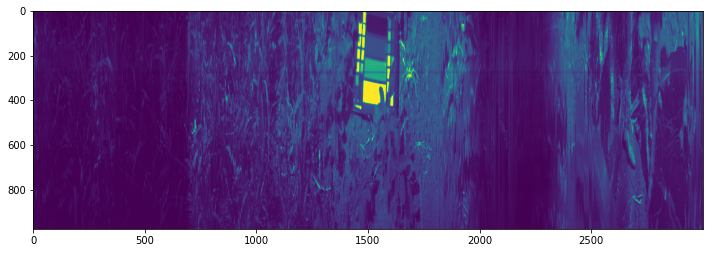

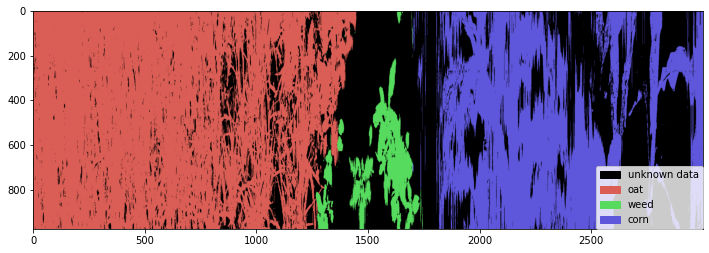

In [7]:
plt.figure(figsize=(12, 12))
plt.imshow(hsi[100])
plt.show()


_ = draw_colored_mask(mask)

## Подсчитаем количество гиперпикселов для каждого из классов

In [8]:
for i in mask.label_class:
    print(i, np.sum(mask.get_2d() == int(i)))

0 965091
1 1170498
2 97718
3 694693


## Зададим параметры обучения

в параметрах оптимизатора укажем шаг и коэффициент уменьшения шага

в основных параметрах укажем:

1) количество эпох

2) процент выборки для обучения из всего набора данных 

3) режим даталоадера

4) размер батча

5) параметры оптимизатора

In [9]:
optimizer_params = {
    "learning_rate": 0.0001,
    "weight_decay": 0
}

fit_params = {
    "epochs": 20,
    "train_sample_percentage": 0.15,
    "dataloader_mode": "fixed",
    "batch_size": 256,
    "optimizer_params": optimizer_params
}

## Создадим модель нейросетевого классификатора SSFTT

1) укажем количество классов в параметре n_classes

2) укажем флаг применения PCA в качестве предобработки по снижению спектральной размерности в параметре apply_pca

3) укажем количество каналов в параметре n_bands (если apply_pca=True, то этот параметр указывает на количество главных компонент после применения РСА)

4) укажем устройство, на котором будут проводиться расчеты в параметре device (в данном случае обучение и инференс будет проводиться на ГПУ)


In [10]:
cnn = SSFTT(n_classes=mask.n_classes,
            apply_pca=True,
            n_bands=30,
            device='cuda')

## Запустим обучение модели, передав объекты ГСИ, маски разметки и параметров обучения 

In [11]:
cnn.fit(X=hsi,
        y=mask,
        fit_params=fit_params)

Will apply PCA from 250 to 30
Sampling fixed with train size = 0.15 for train_val/test
Sampling fixed with train size = 0.9 for train/val


Train loop: 100%|█| 20/20 [22:00<00:00, 66.00s/it, train accuracy: 0.9997036101819525	val accuracy: 0.9993771410775459	


## Отрисуем графики обучения

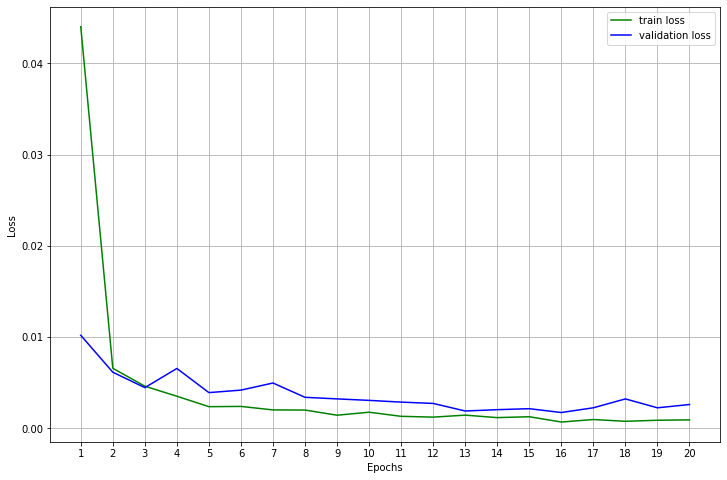

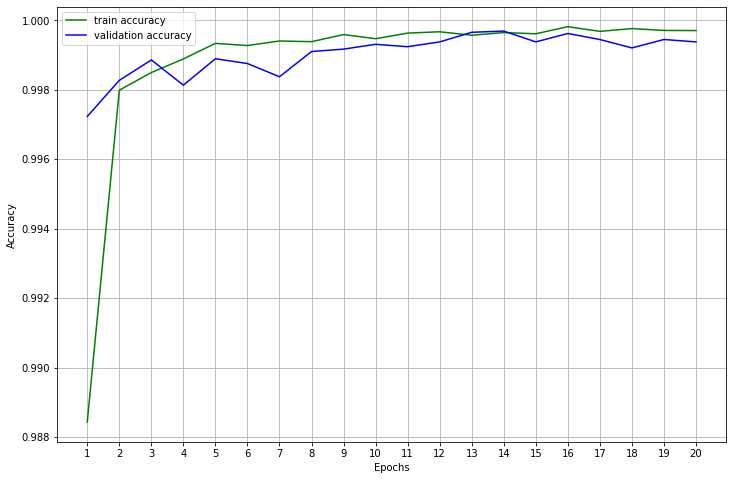

In [12]:
draw_fit_plots(model=cnn)

## Запустим инференс модели и оставим только целевые классы

In [13]:
pred = cnn.predict(X=hsi, y=mask)

pred = pred * (mask.get_2d() > 0)

Will apply PCA from 250 to 30


Inference on the image: 45007it [02:06, 356.59it/s]                                                                    


## Отрисуем эталонную маску разметки и предсказанную

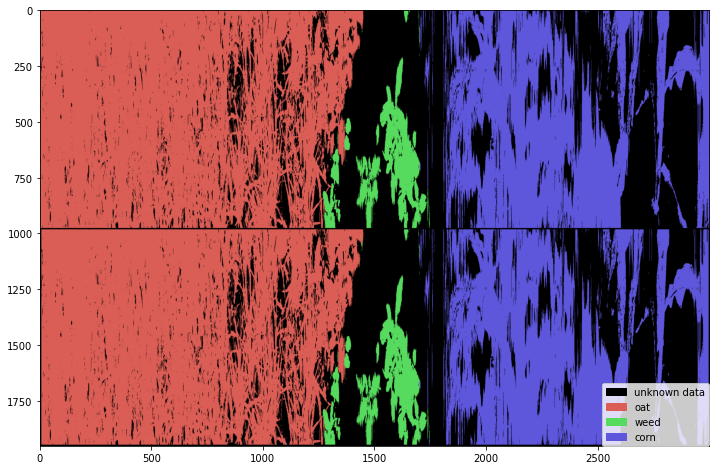

In [14]:
_ = draw_colored_mask(mask, pred)

## Рассчитаем метрики классификации

In [15]:
print(classification_report(pred.flatten(), mask.get_2d().flatten()))


              precision    recall  f1-score   support

           0       1.00      0.97      0.98    999761
           1       0.98      1.00      0.99   1150090
           2       0.99      1.00      0.99     96779
           3       0.98      1.00      0.99    681370

    accuracy                           0.99   2928000
   macro avg       0.99      0.99      0.99   2928000
weighted avg       0.99      0.99      0.99   2928000

